# **How to plot multiple waveforms in a single picture**
This notebook provides some example to select waveform data according to the metadata provided. 

This has been used to generate figures 14, 15, 16 and 20 of the article....

In [1]:
import string
import argparse as ap
import sys
import os
import numpy as np

import obspy
import obspy.core as oc
from obspy import read_inventory

# from datetime import datetime, timedelta
import time

import pylab as plt
import pandas as pd
import h5py


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime

mpl.rcParams['pdf.fonttype'] = 42

## Define the path to metadata and hdf5 files

In [2]:
# directory PATH
METADIR = '../metadata'
HDFDIR = '../data'
FIGDIR='../samples'

# file NAMES
# MetaData
events_metaname=os.path.join(METADIR,'metadata_Events_10k.csv') # Either Counts and GroundMotion
noise_metaname=os.path.join(METADIR,'metadata_Noise_10k.csv')
# HDF5
events_hdfname=os.path.join(HDFDIR,'Instance_Evs_Counts10k.hdf5')
gm_hdfname=os.path.join(HDFDIR,'Instance_Evs_Corrected10k.hdf5')
noise_hdfname=os.path.join(HDFDIR,'Instance_Noise_Counts10k.hdf5')
# Figures
# events_figname=os.path.join(FIGDIR,'waveforms_Evs.png')
# gm_figname=os.path.join(FIGDIR,'waveforms_Evs_gm.png')
# noise_figname=os.path.join(FIGDIR,'waveforms_Noise.png')

## Read metadata for events and noise

In [3]:
events_metaData = pd.read_csv(events_metaname, keep_default_na=False, dtype={'station_location_code': object, 
           'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
           'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object})

/homes/cianetti/.conda/envs/gpd/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (57,58,62,75,76,77,79,87,95,103) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
noise_metaData = pd.read_csv(noise_metaname,dtype={'station_location_code': object})

## You can also read bz2 directly

In [5]:
# events_metaname_bz2 = os.path.join(METADIR,'events.csv.bz2')
# events_metaData = pd.read_csv(events_metaname_bz2, keep_default_na=False, dtype={'station_location_code': object, 
#            'source_mt_eval_mode':object,'source_mt_status': object,'source_mechanism_strike_dip_rake': object, 
#            'source_mechanism_moment_tensor': object, 'trace_p_arrival_time': object, 'trace_s_arrival_time': object})

## Read Waveforms hdf5 files

In [6]:
events_h5File = h5py.File(events_hdfname, 'r') # Events in counts
gm_h5File = h5py.File(gm_hdfname, 'r')         # Events in ground motion units
noise_h5File = h5py.File(noise_hdfname, 'r')   # Noise in counts

## Load plot function

In [7]:
sys.path.append('./Def_plot_waveform.py')

In [8]:
from Def_plot_waveform import split, build_stream, multiple_streams

## Figure labels

In [9]:
fignumbers = 'abcdefghijklmnopqrstuvwxyz'
alllabs = split(fignumbers)

## Here is the list of available metadata for events

In [10]:
events_metaData.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 117 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        10000 non-null  int64  
 1   source_id                         10000 non-null  int64  
 2   station_network_code              10000 non-null  object 
 3   station_code                      10000 non-null  object 
 4   station_location_code             10000 non-null  object 
 5   station_channels                  10000 non-null  object 
 6   station_latitude_deg              10000 non-null  float64
 7   station_longitude_deg             10000 non-null  float64
 8   station_elevation_m               10000 non-null  float64
 9   station_vs_30                     10000 non-null  float64
 10  station_vs_30_detail              10000 non-null  object 
 11  source_origin_time                10000 non-null  object 
 12  sour

## Here is the list of available metadata for noise

In [11]:
noise_metaData.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   source_id               10000 non-null  object 
 1   station_network_code    10000 non-null  object 
 2   station_code            10000 non-null  object 
 3   station_location_code   0 non-null      object 
 4   station_channels        10000 non-null  object 
 5   station_latitude_deg    10000 non-null  float64
 6   station_longitude_deg   10000 non-null  float64
 7   station_elevation_m     10000 non-null  float64
 8   station_vs_30           10000 non-null  float64
 9   station_vs_30_detail    10000 non-null  object 
 10  trace_start_time        10000 non-null  object 
 11  trace_dt                10000 non-null  float64
 12  trace_npts              10000 non-null  int64  
 13  trace_E_median          10000 non-null  float64
 14  trace_N_median          10000 non-null 

## Convert argument of metadata columns with different type to numeric.

In [12]:
## 
events_metaData['trace_E_min_counts'] =  pd.to_numeric(events_metaData['trace_E_min_counts'], errors='coerce')
events_metaData['trace_N_min_counts'] =  pd.to_numeric(events_metaData['trace_E_min_counts'], errors='coerce')
events_metaData['trace_Z_min_counts'] =  pd.to_numeric(events_metaData['trace_Z_min_counts'], errors='coerce')
#
events_metaData['trace_E_max_counts'] =  pd.to_numeric(events_metaData['trace_E_max_counts'], errors='coerce')
events_metaData['trace_N_max_counts'] =  pd.to_numeric(events_metaData['trace_N_max_counts'], errors='coerce')
events_metaData['trace_Z_max_counts'] =  pd.to_numeric(events_metaData['trace_Z_max_counts'], errors='coerce')
#
events_metaData['trace_E_median_counts'] =  pd.to_numeric(events_metaData['trace_E_median_counts'], errors='coerce')
events_metaData['trace_N_median_counts'] =  pd.to_numeric(events_metaData['trace_N_median_counts'], errors='coerce')
events_metaData['trace_Z_median_counts'] =  pd.to_numeric(events_metaData['trace_Z_median_counts'], errors='coerce')
#
events_metaData['trace_E_mean_counts'] =  pd.to_numeric(events_metaData['trace_E_mean_counts'], errors='coerce')
events_metaData['trace_N_mean_counts'] =  pd.to_numeric(events_metaData['trace_N_mean_counts'], errors='coerce')
events_metaData['trace_Z_mean_counts'] =  pd.to_numeric(events_metaData['trace_Z_mean_counts'], errors='coerce')
#
#

In [13]:
events_metaData['trace_E_pga_perc'] =  pd.to_numeric(events_metaData['trace_E_pga_perc'], errors='coerce')
events_metaData['trace_N_pga_perc'] =  pd.to_numeric(events_metaData['trace_N_pga_perc'], errors='coerce')
events_metaData['trace_Z_pga_perc'] =  pd.to_numeric(events_metaData['trace_Z_pga_perc'], errors='coerce')


In [14]:
events_metaData['trace_E_pga_cmps2'] = pd.to_numeric(events_metaData['trace_E_pga_cmps2'],errors='coerce')
events_metaData['trace_N_pga_cmps2'] = pd.to_numeric(events_metaData['trace_N_pga_cmps2'],errors='coerce')
events_metaData['trace_Z_pga_cmps2'] = pd.to_numeric(events_metaData['trace_Z_pga_cmps2'],errors='coerce')

In [15]:
events_metaData['trace_E_pgv_cmps'] = pd.to_numeric(events_metaData['trace_E_pgv_cmps'],errors='coerce')
events_metaData['trace_N_pgv_cmps'] = pd.to_numeric(events_metaData['trace_N_pgv_cmps'],errors='coerce')
events_metaData['trace_Z_pgv_cmps'] = pd.to_numeric(events_metaData['trace_Z_pgv_cmps'],errors='coerce')

In [16]:
events_metaData['trace_E_snr_db'] =  pd.to_numeric(events_metaData['trace_E_snr_db'], errors='coerce')
events_metaData['trace_N_snr_db'] =  pd.to_numeric(events_metaData['trace_N_snr_db'], errors='coerce')
events_metaData['trace_Z_snr_db'] =  pd.to_numeric(events_metaData['trace_Z_snr_db'], errors='coerce')

In [17]:
events_metaData['trace_EQT_number_detections'] = pd.to_numeric(events_metaData['trace_EQT_number_detections'],errors='coerce')
events_metaData['trace_EQT_P_number'] = pd.to_numeric(events_metaData['trace_EQT_P_number'],errors='coerce')
events_metaData['trace_EQT_S_number'] = pd.to_numeric(events_metaData['trace_EQT_S_number'],errors='coerce')
events_metaData['trace_GPD_P_number'] = pd.to_numeric(events_metaData['trace_GPD_P_number'],errors='coerce')
events_metaData['trace_GPD_S_number'] = pd.to_numeric(events_metaData['trace_GPD_S_number'],errors='coerce')

In [18]:
events_metaData['trace_E_sa03_cmps2'] = pd.to_numeric(events_metaData['trace_E_sa03_cmps2'],errors='coerce')
events_metaData['trace_E_sa10_cmps2'] = pd.to_numeric(events_metaData['trace_E_sa10_cmps2'],errors='coerce')
events_metaData['trace_E_sa30_cmps2'] = pd.to_numeric(events_metaData['trace_E_sa30_cmps2'],errors='coerce')

In [19]:
events_metaData['trace_pgv_cmps'] =  pd.to_numeric(events_metaData['trace_pgv_cmps'], errors='coerce')

In [20]:
events_metaData['trace_pga_perc'] =  pd.to_numeric(events_metaData['trace_pga_perc'], errors='coerce')

# Perform some particular traces selections

# Select waveforms for Figure 14
Example  of  randomly  selected  earthquake  waveforms  of  the  broadband  HH  channels  contained  in  INSTANCE.  Each  row contains three randomly selected traces drawn according to the following criteria: (a-c) earthquakes 2≤M< 3 (66.8 % of the total of the HH channels); (d-f) earthquakes 3≤M<4 (13.5 %); (g-i) earthquakes M≥4 (2.0 %); (j-l) earthquakes `trace_E_snr_db`≥10 and `path_ep_distance`<100 km (55.0 %); (m-o) earthquakes `trace_E_snr_db`≥10 and `path_ep_distance`≥100 km (10.8 %);(p-r) earthquakes M≥4 and `trace_E_snr_db`≥10 (1.7 %). The arrival times of P- and S-wave onsets are shown by blue and redvertical lines, respectively

In [21]:
cha = 'HH'

In [22]:
# TOTAL = events_metaData.shape[0]
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]
TOTAL

3893

In [23]:
chosen_lines = []
plots_line = 3

#### 1) select earthquakes with 2 $\le$ `source_magnitude` < 3 and `station_channels` = 'HH'

In [24]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 2) &
                             (events_metaData.source_magnitude < 3) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  2291 % total:  58.84921654251221


[6190, 3485, 9682]

#### 2) select earthquakes with 3 $\le$ `source_magnitude` < 4 and `station_channels` = 'HH'

In [25]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 3) &
                             (events_metaData.source_magnitude < 4) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  783 % total:  20.11302337528898


[6190, 3485, 9682, 9431, 5307, 3591]

#### 3) select earthquakes with `source_magnitude` $\ge$ 4 and `station_channels` = 'HH'

In [26]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 4) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  70 % total:  1.7980991523246854


[6190, 3485, 9682, 9431, 5307, 3591, 9991, 8849, 9993]

#### 4) select earthquakes with `trace_E_snr_db` $\ge$ 10, `path_ep_distance_km` < 100 km and `station_channels` = 'HH'

In [27]:
df_tmp = events_metaData.loc[(events_metaData.trace_E_snr_db >= 10) &
                             (events_metaData.path_ep_distance_km < 100) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  2388 % total:  61.340868225019264


[6190, 3485, 9682, 9431, 5307, 3591, 9991, 8849, 9993, 9017, 7014, 2327]

#### 5) select earthquakes with `trace_E_snr_db` $\ge$ 10, `path_ep_distance_km` $\ge$ 100 km and `station_channels` = 'HH'

In [28]:
df_tmp = events_metaData.loc[(events_metaData.trace_E_snr_db >= 10) &
                             (events_metaData.path_ep_distance_km >= 100) & 
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  444 % total:  11.405086051888004


[6190,
 3485,
 9682,
 9431,
 5307,
 3591,
 9991,
 8849,
 9993,
 9017,
 7014,
 2327,
 8124,
 5408,
 5437]

#### 6) select earthquakes with `source_magnitude` $\ge$ 4, `trace_E_snr_db`  $\ge$ 10 and `station_channels` = 'HH'

In [29]:
df_tmp = events_metaData.loc[(events_metaData.source_magnitude >= 4) &
                             (events_metaData.trace_E_snr_db >= 10) &
                             (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  64 % total:  1.6439763678397123


[6190,
 3485,
 9682,
 9431,
 5307,
 3591,
 9991,
 8849,
 9993,
 9017,
 7014,
 2327,
 8124,
 5408,
 5437,
 8854,
 9958,
 9979]

## Plot waveforms in Counts

/homes/cianetti/INSTANCE/github/notebooks/Def_plot_waveform.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


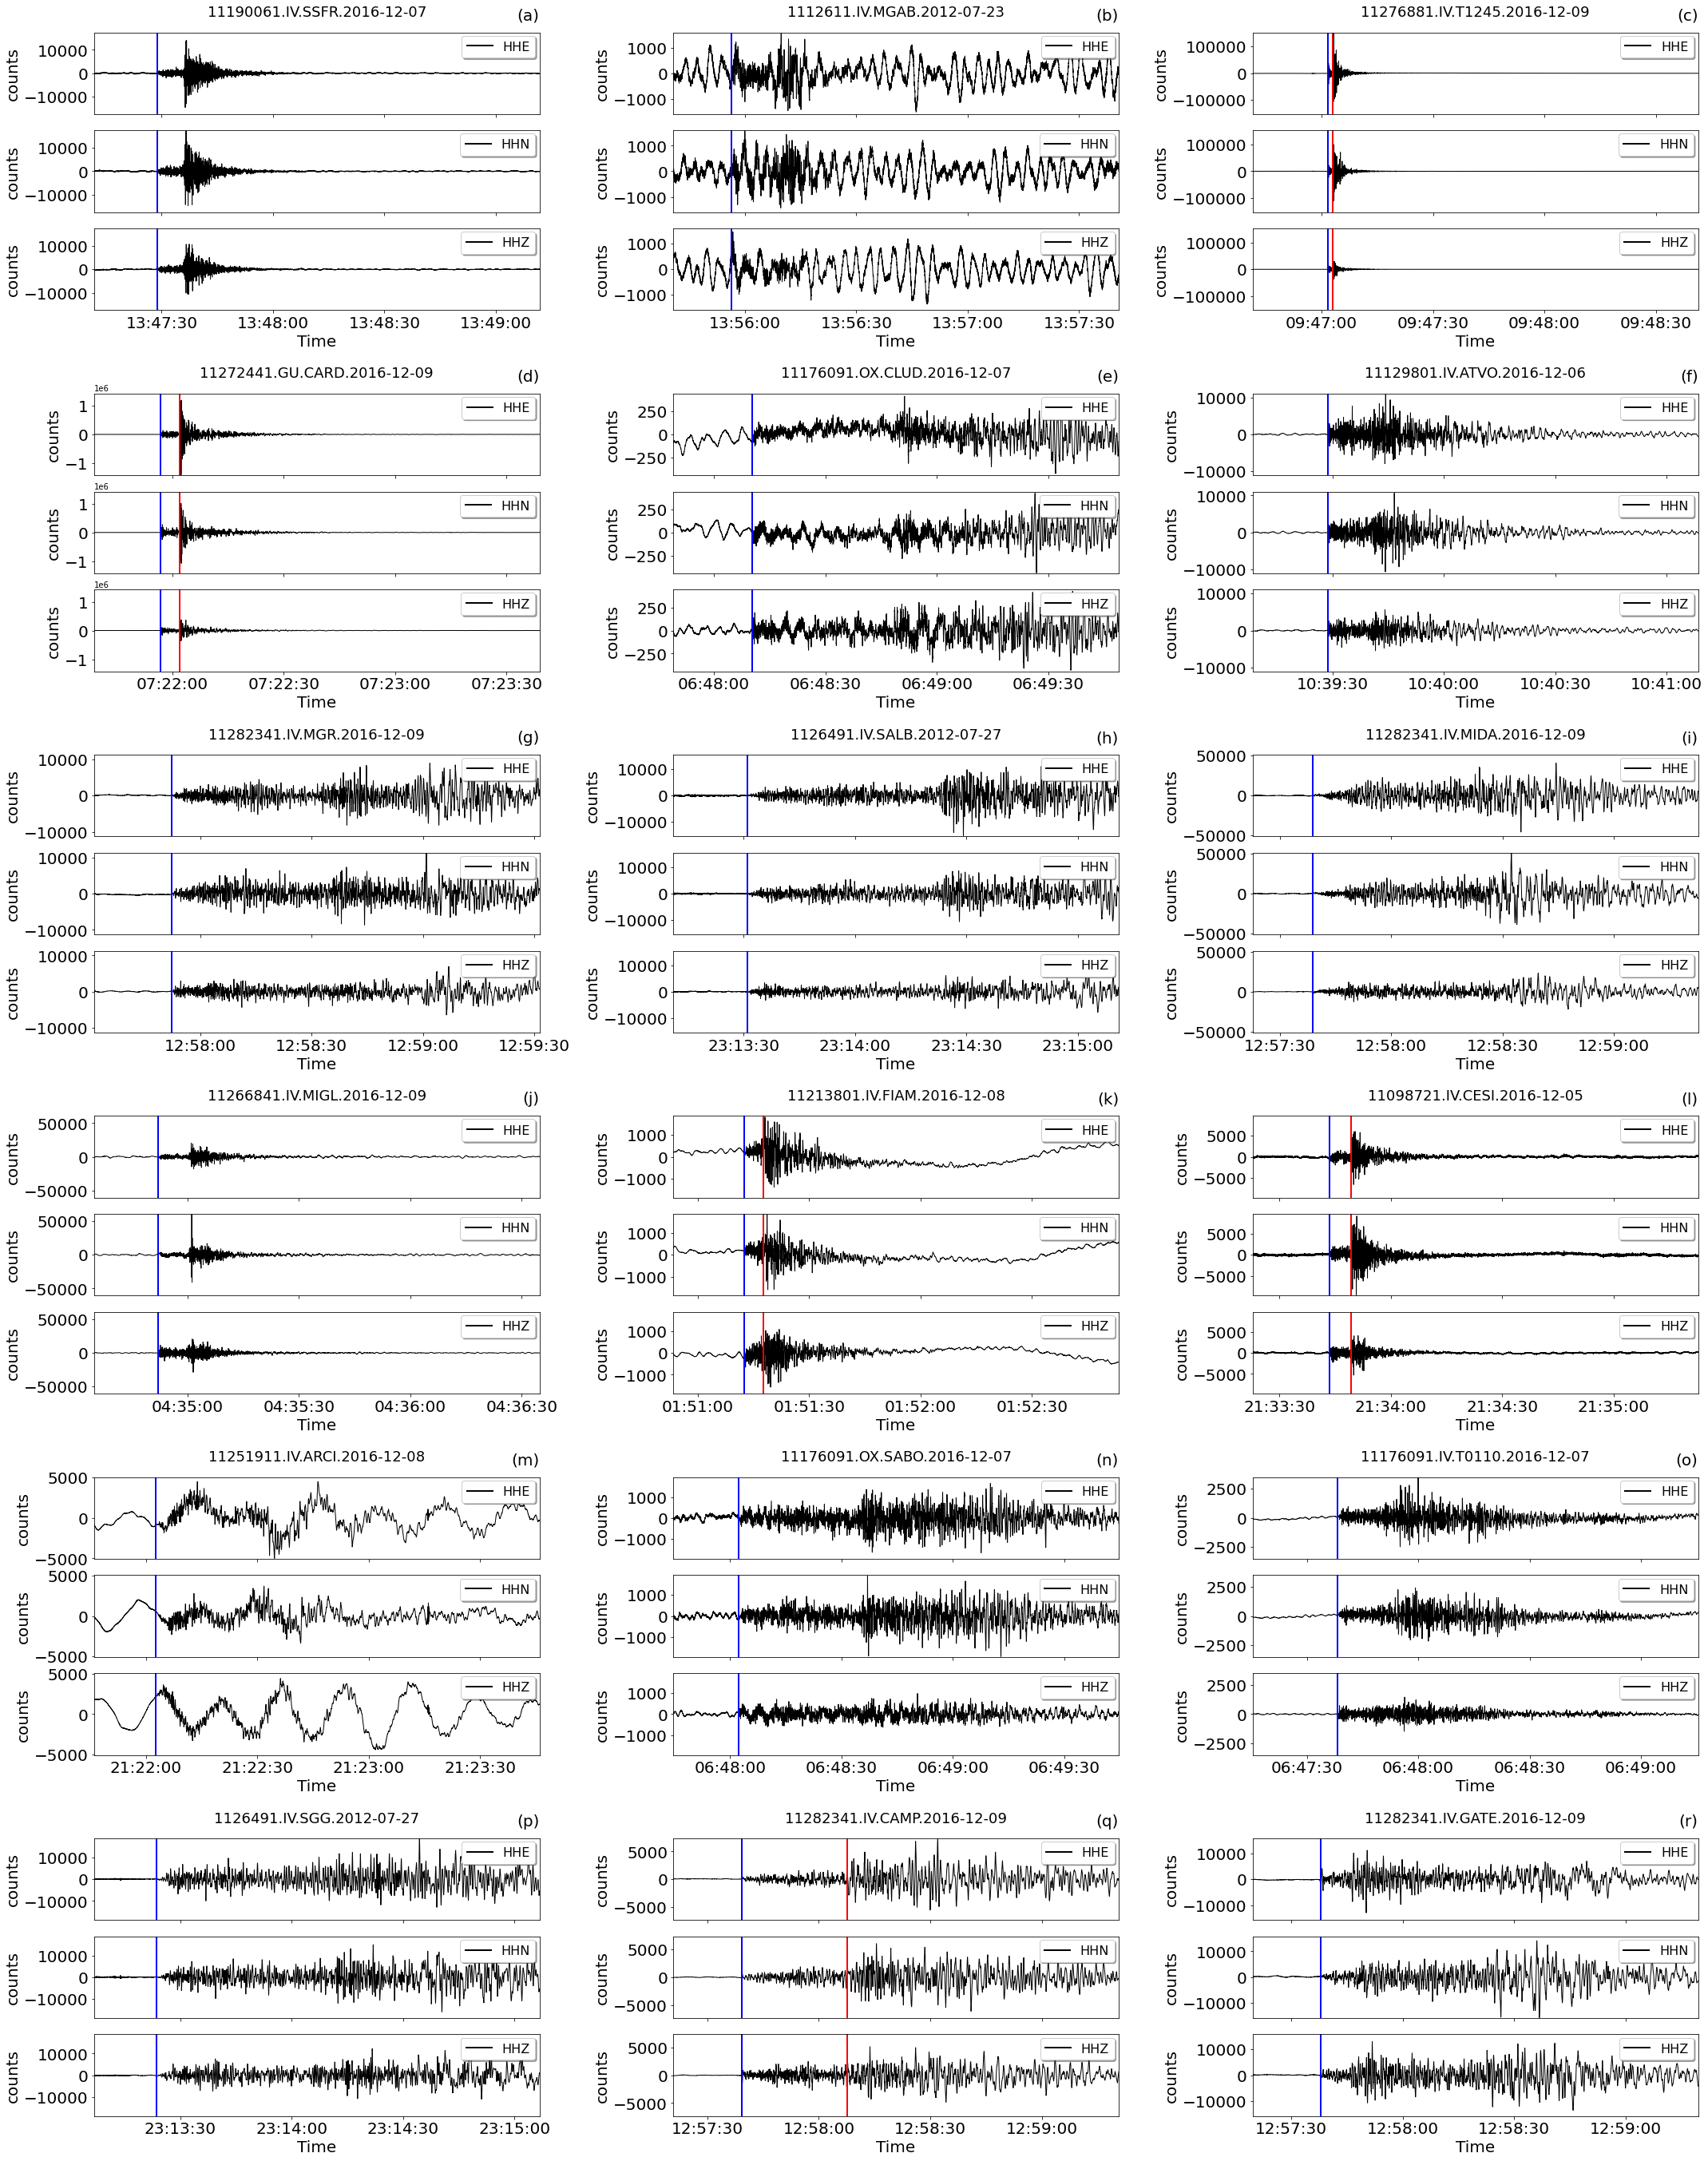

In [31]:
lines = chosen_lines
# Kind of unit
units = ["counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]

wftype='ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File

multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)
gm_figname=os.path.join(FIGDIR,'we_14.png')
plt.savefig(gm_figname,dpi=300)



## Plot same list ov events in Ground Motion Units

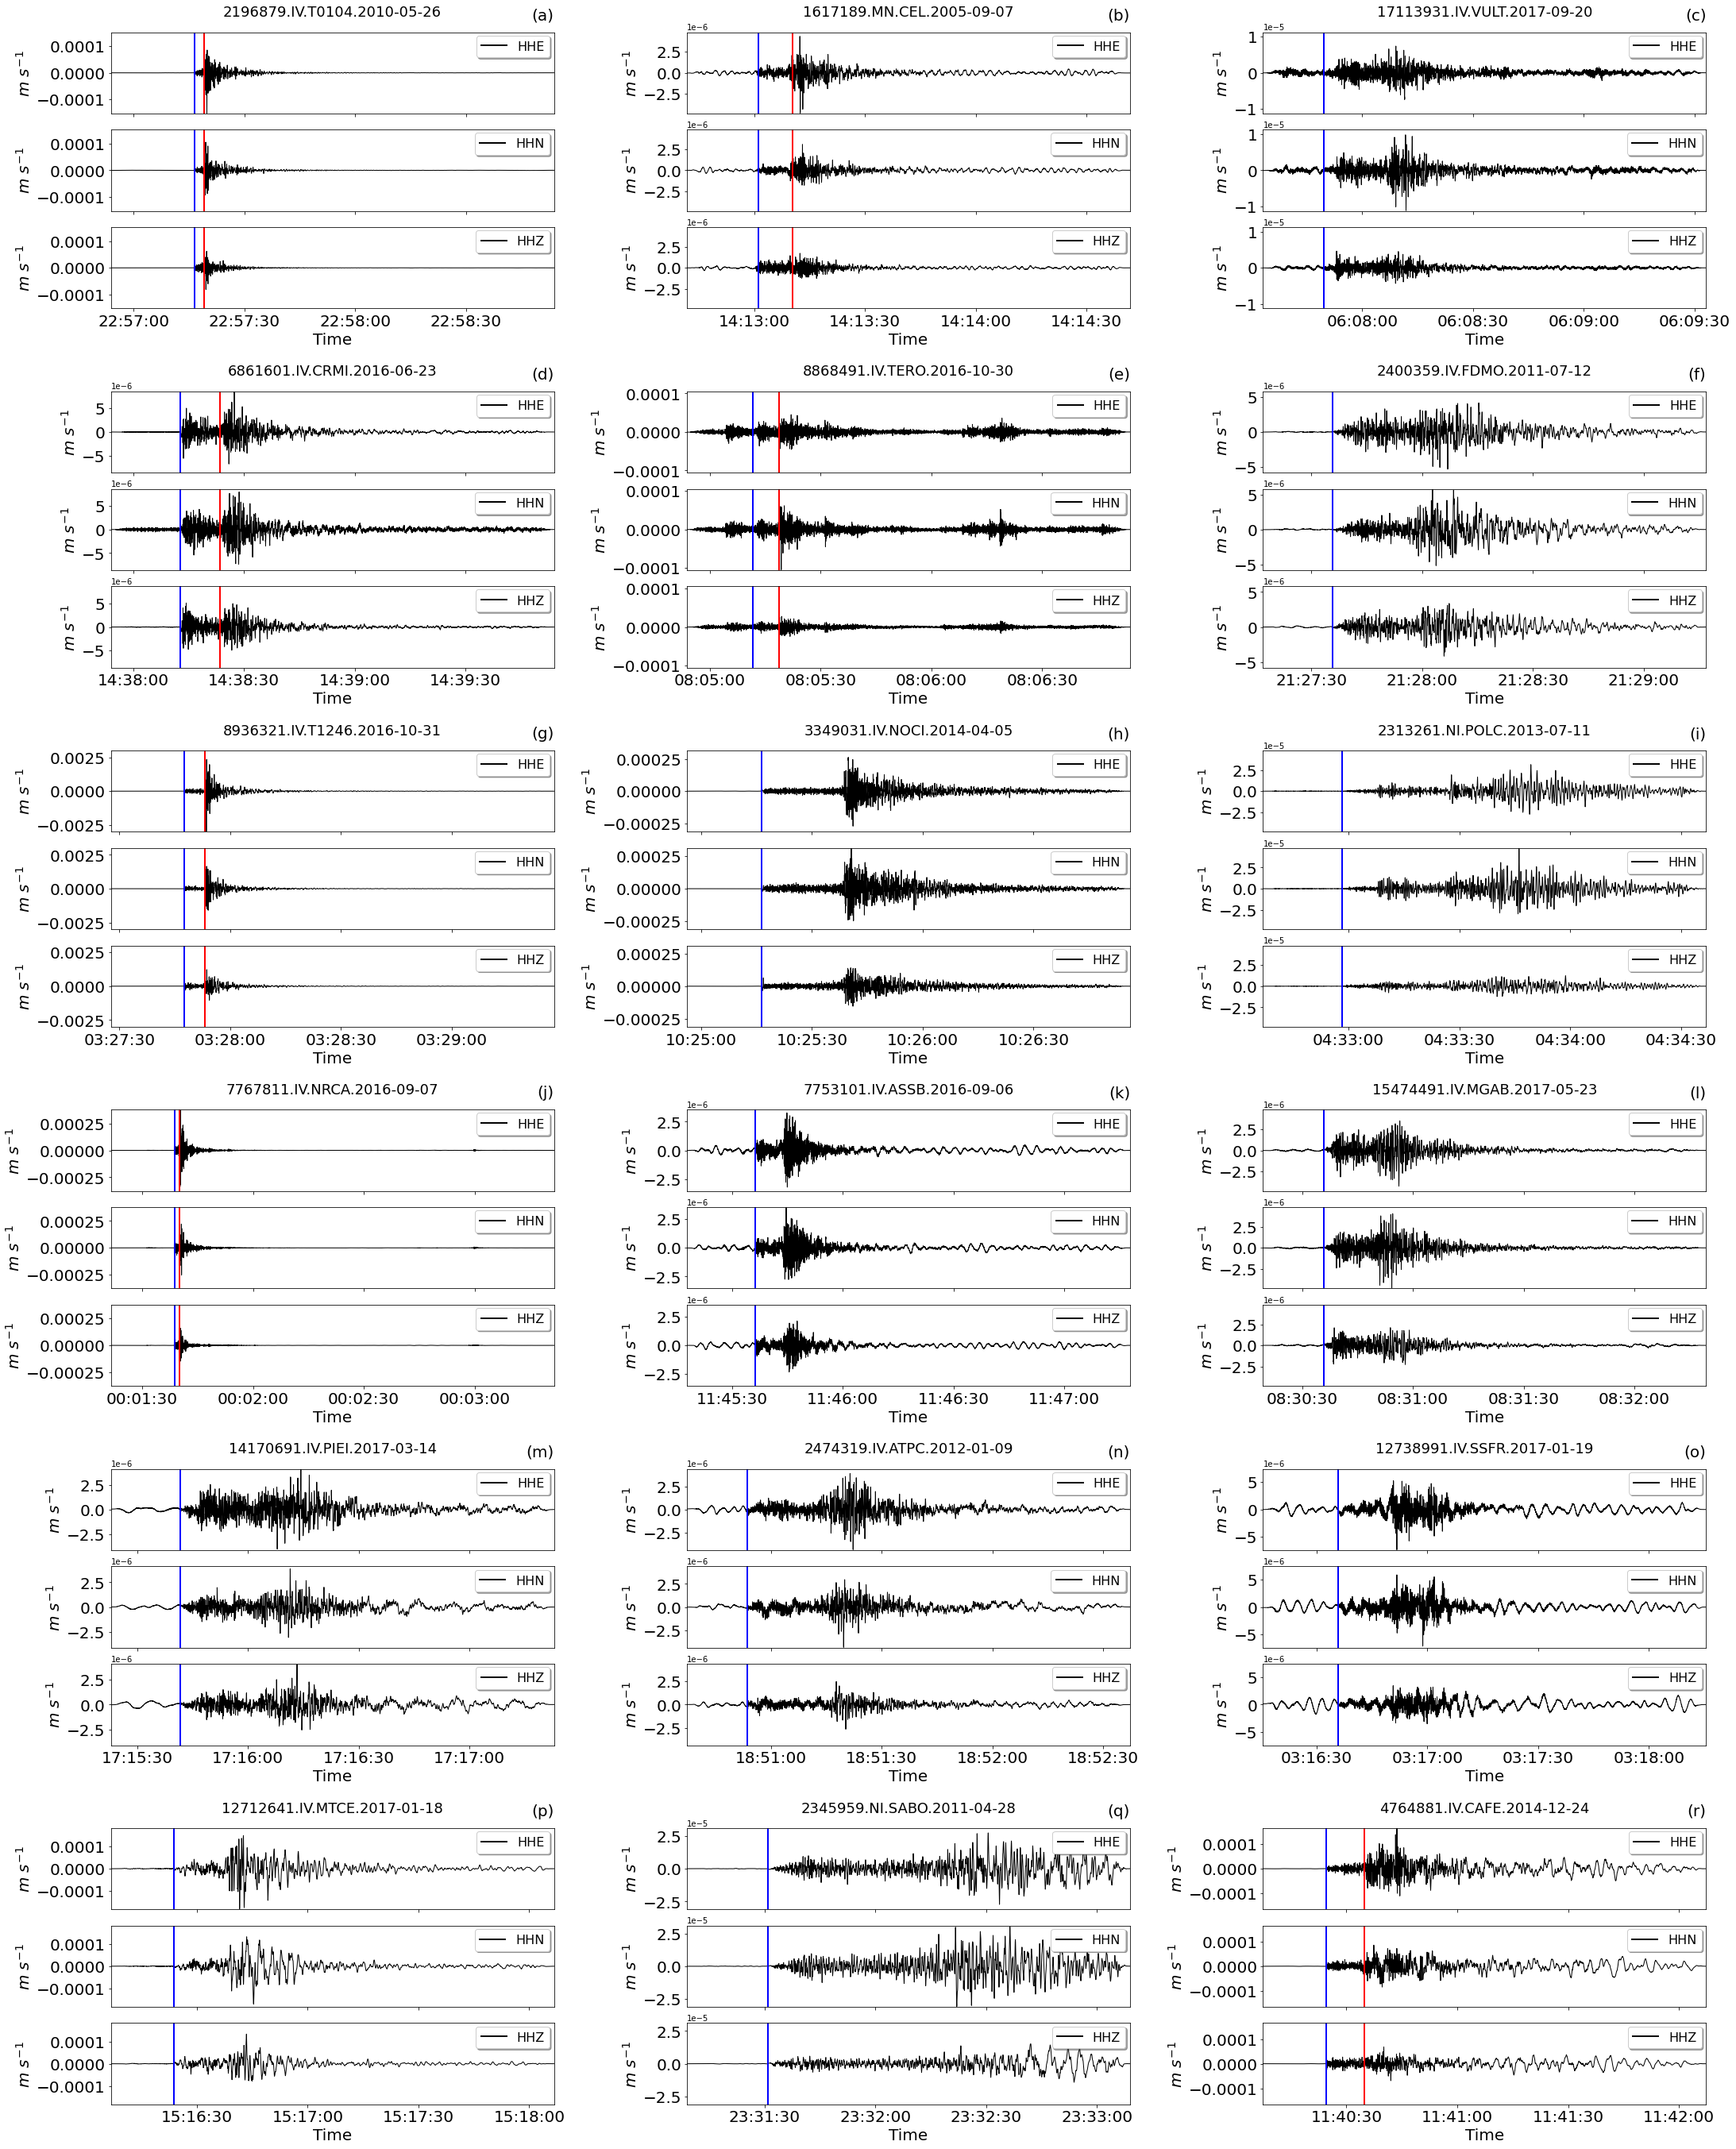

In [31]:
units = ["$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$"]

wftype='ev_gm'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)
gm_figname=os.path.join(FIGDIR,'wegm_14.png')
plt.savefig(gm_figname,dpi=300)


# Select waveforms for Figure 15
Example of randomly selected problematic earthquake waveforms of the broadband HH channels. Each row contains threerandomly selected traces drawn according to the following criteria: (a-c) traces with `trace_GPD_[P,S]_number` > 3 (7.96 % of thetotal of the HH channels); (d-f) traces with `trace_EQT_number_detections` > 3 (0.38 % of the total of the HH channels); (g-i) traces `trace_[ENZ]_snr_db` with at least one component in the 10% quantile (18.10 % of the total of the HH channels); (j-l) traces with all `trace_[ENZ]_median_counts` either in the first 10% or the last 10% quantiles (5.90 % of the total of the HH channels); (m-o) traces with `trace_[ENZ]_median_counts` either in the first 10% or the last 10% quantiles and corresponding `trace_[ENZ]_snr_db` excluded from the first quartile (5.06 % HH dataset). The arrival times of P- and S-wave onsets are shown by blue and red vertical lines,respectively.

In [32]:
cha = 'HH'

In [33]:
# TOTAL = events_metaData.shape[0]
TOTAL = events_metaData.loc[events_metaData.station_channels == cha].shape[0]
TOTAL

3893

### Define selection criteria based on metadata statistics

In [34]:
df_tmp = events_metaData.loc[(events_metaData.station_channels == cha)]
percents = [0.1, 0.25, 0.75, 0.9]
df_tmp[['trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
        'trace_E_snr_db','trace_N_snr_db','trace_Z_snr_db' ,
        'trace_E_rms_counts', 'trace_N_rms_counts','trace_Z_rms_counts']].describe(percentiles=percents)

trace_E_median_counts  trace_N_median_counts  trace_Z_median_counts  \
count            3893.000000            3893.000000            3893.000000   
mean               26.008862               7.812741              68.759954   
std              1669.505451             760.585669            4398.266715   
min             -6622.000000          -13263.000000          -10247.500000   
10%               -32.000000             -32.000000             -12.000000   
25%                -7.000000              -8.000000              -2.000000   
50%                 0.000000               0.000000               0.000000   
75%                 7.000000               8.000000               3.000000   
90%                32.000000              34.000000              12.000000   
max            102677.500000           37610.500000          273372.000000   

       trace_E_snr_db  trace_N_snr_db  trace_Z_snr_db  trace_E_rms_counts  \
count     3886.000000     3886.000000     3886.000000         3893.000000   
mean        20.119065       20.280529       18.125744         2746.800319   
std         14.071459       13.959102       13.420478        12530.073958   
min        -13.440470      -13.249896      -13.879028           17.814718   
10%          3.309558        3.491138        2.583829          102.565152   
25%          9.337772        9.376121        7.658003          203.568631   
50%         18.120288       18.608185       16.216453          517.637210   
75%         29.238424       29.569234       26.501679         1627.774097   
90%         39.694378       39.754478       36.505801         5213.680651   
max         74.336617       73.574390       68.742970       583182.284666   

       trace_N_rms_counts  trace_Z_rms_counts  
count         3893.000000        3.893000e+03  
mean          2773.775523        2.051061e+03  
std           9827.570266        2.517532e+04  
min             15.978491        1.653521e+01  
10%            101.953430        5.877876e+01  
25%            205.588313        1.297846e+02  
50%            529.269350        3.177163e+02  
75%           1634.950136        9.819552e+02  
90%           5177.258972        3.197054e+03  
max         246606.517802        1.535769e+06

In [35]:
chosen_lines = []
plots_line = 3

#### 1) select earthquakes with `trace_GPD_[P,S]_number` > 3 and `station_channels` = 'HH'

In [36]:
df_tmp = events_metaData.loc[((events_metaData.trace_GPD_P_number > 3) | (events_metaData.trace_GPD_S_number > 3)) & 
                    (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=3).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  1291 % total:  33.1620857950167


[5035, 4321, 2271]

#### 2) select earthquakes with `trace_EQT_number_detections` > 3 and `station_channels` = 'HH'

In [37]:
df_tmp = events_metaData.loc[(events_metaData.trace_EQT_number_detections > 3) & 
                    (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  51 % total:  1.3100436681222707


[5035, 4321, 2271, 3958, 293, 9065]

#### 3) select earthquakes with at least one component `trace_[ENZ]_snr_db` in the 10% quantile and `station_channels` = 'HH'

In [38]:
snrv_E, snrv_N, snrv_Z = (2.313, 2.297, 1.2118)
df_tmp = events_metaData.loc[((events_metaData.trace_E_snr_db < snrv_E)| (events_metaData.trace_N_snr_db < snrv_N) | (events_metaData.trace_Z_snr_db < snrv_Z))
                      & (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  542 % total:  13.922424865142563


[5035, 4321, 2271, 3958, 293, 9065, 9751, 2674, 1587]

#### 4) select earthquakes with `trace_[ENZ]_median_counts` in the 10% or 90% quantile and `station_channels` = 'HH'

In [39]:
min_threv_E, min_threv_N, min_threv_Z = (-22.0, -22.0, -11.5)
max_threv_E, max_threv_N, max_threv_Z = (22.0, 22.5, 12.0)

df_tmp = events_metaData.loc[(((events_metaData.trace_E_median_counts < min_threv_E) | (events_metaData.trace_E_median_counts > max_threv_E)) & 
                    ((events_metaData.trace_N_median_counts < min_threv_N) | (events_metaData.trace_N_median_counts > max_threv_N)) &
                    ((events_metaData.trace_Z_median_counts < min_threv_Z) | (events_metaData.trace_Z_median_counts > max_threv_Z)))  & 
                      (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  357 % total:  9.170305676855897


[5035, 4321, 2271, 3958, 293, 9065, 9751, 2674, 1587, 8321, 8099, 9445]

#### 5) select  earthquake  with `trace_[ENZ]_median_counts` in the first and last 10%, `trace_[ENZ]_snr_db` above 25% and `station_channels` = 'HH'

In [40]:
# 10%
min_threv_E, min_threv_N, min_threv_Z = (-22.0, -22.0, -11.5)
max_threv_E, max_threv_N, max_threv_Z = (22.0, 22.5, 12.0)

# 25%
snrv_E, snrv_N, snrv_Z = (7.29, 7.273, 5.506)

df_tmp = events_metaData.loc[(((events_metaData.trace_E_median_counts < min_threv_E) | (events_metaData.trace_E_median_counts > max_threv_E)) & 
                    ((events_metaData.trace_N_median_counts < min_threv_N) | (events_metaData.trace_N_median_counts > max_threv_N)) &
                    ((events_metaData.trace_Z_median_counts < min_threv_Z) | (events_metaData.trace_Z_median_counts > max_threv_Z)))  &
                    ((events_metaData.trace_E_snr_db > snrv_E) | (events_metaData.trace_N_snr_db > snrv_N) | (events_metaData.trace_Z_snr_db > snrv_Z)) &
                      (events_metaData.station_channels == cha)]
#
ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  299 % total:  7.680452093501156


[5035,
 4321,
 2271,
 3958,
 293,
 9065,
 9751,
 2674,
 1587,
 8321,
 8099,
 9445,
 7848,
 9821,
 2796]

## Plot waveforms in Counts

/homes/cianetti/INSTANCE/github/notebooks/Def_plot_waveform.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


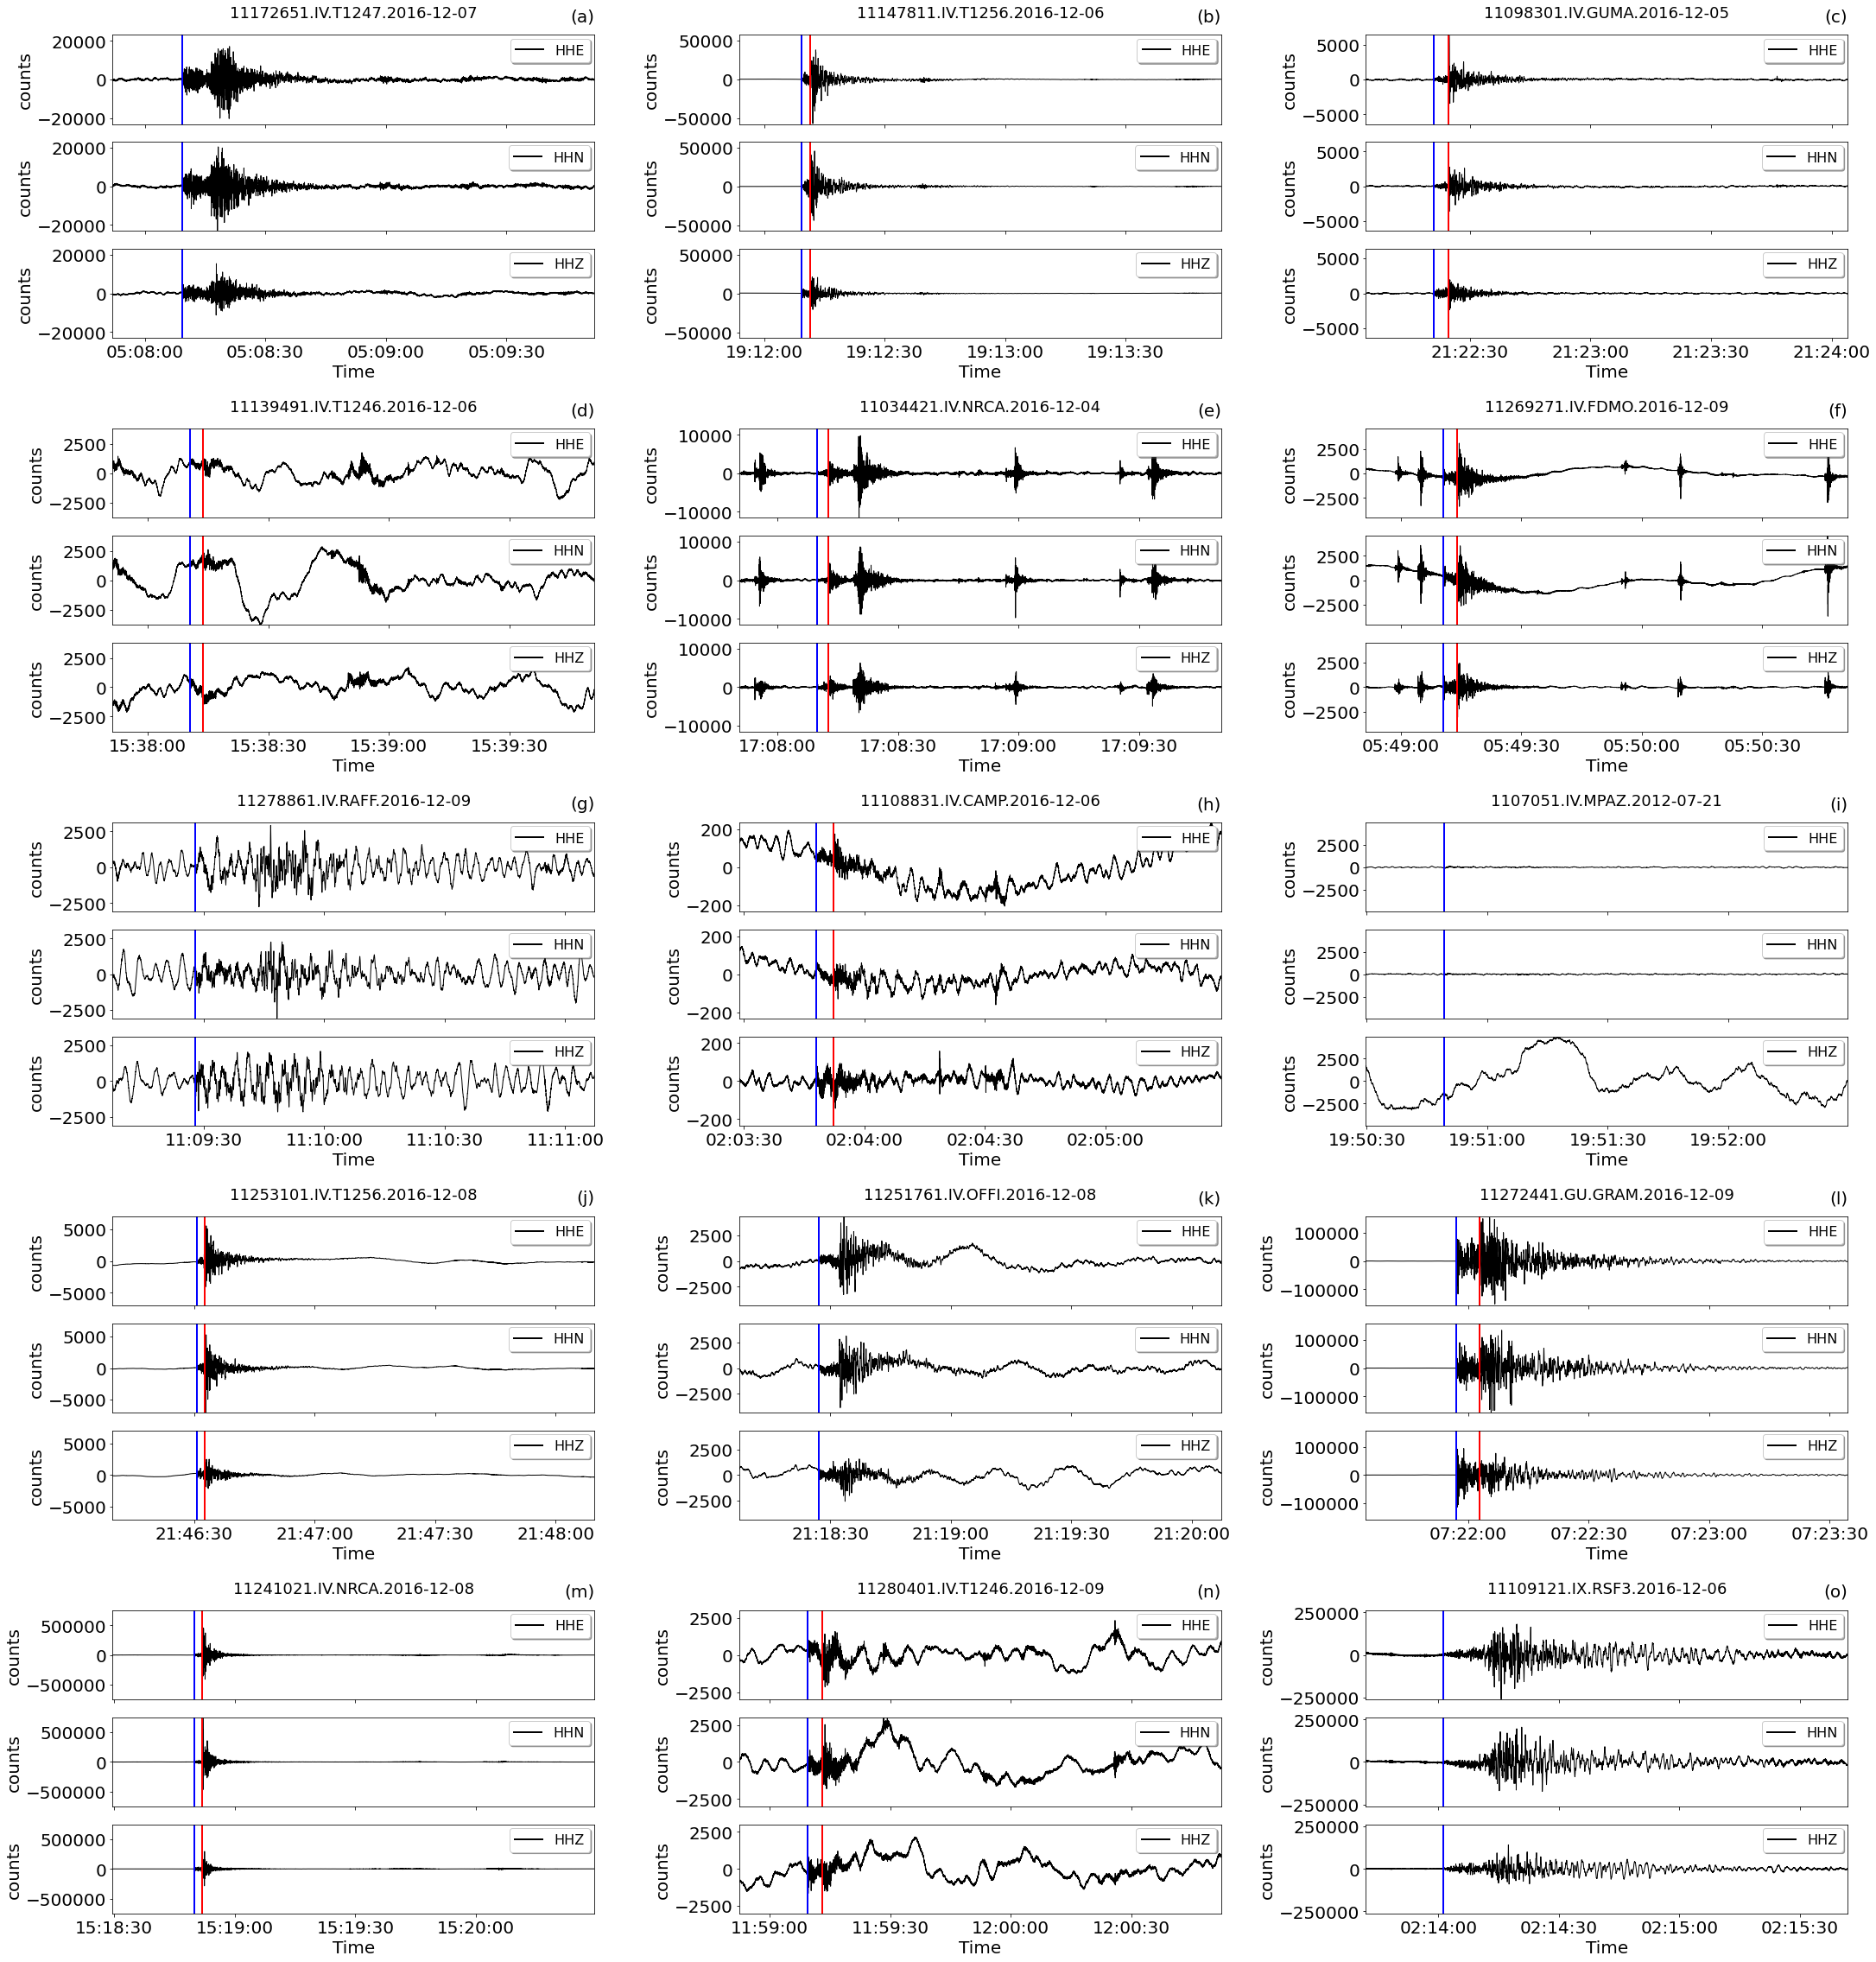

In [41]:
lines = chosen_lines
# Kind of unit
units = ["counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts",
         "counts","counts","counts"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=int(len(lines)/plots_line)
ncol=plots_line

labs = alllabs[:(ncol*nrow)]
wftype = 'ev_c'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

gm_figname=os.path.join(FIGDIR,'we_15.png')
plt.savefig(gm_figname,dpi=300)



## Plot same list of events in Ground Motion Units

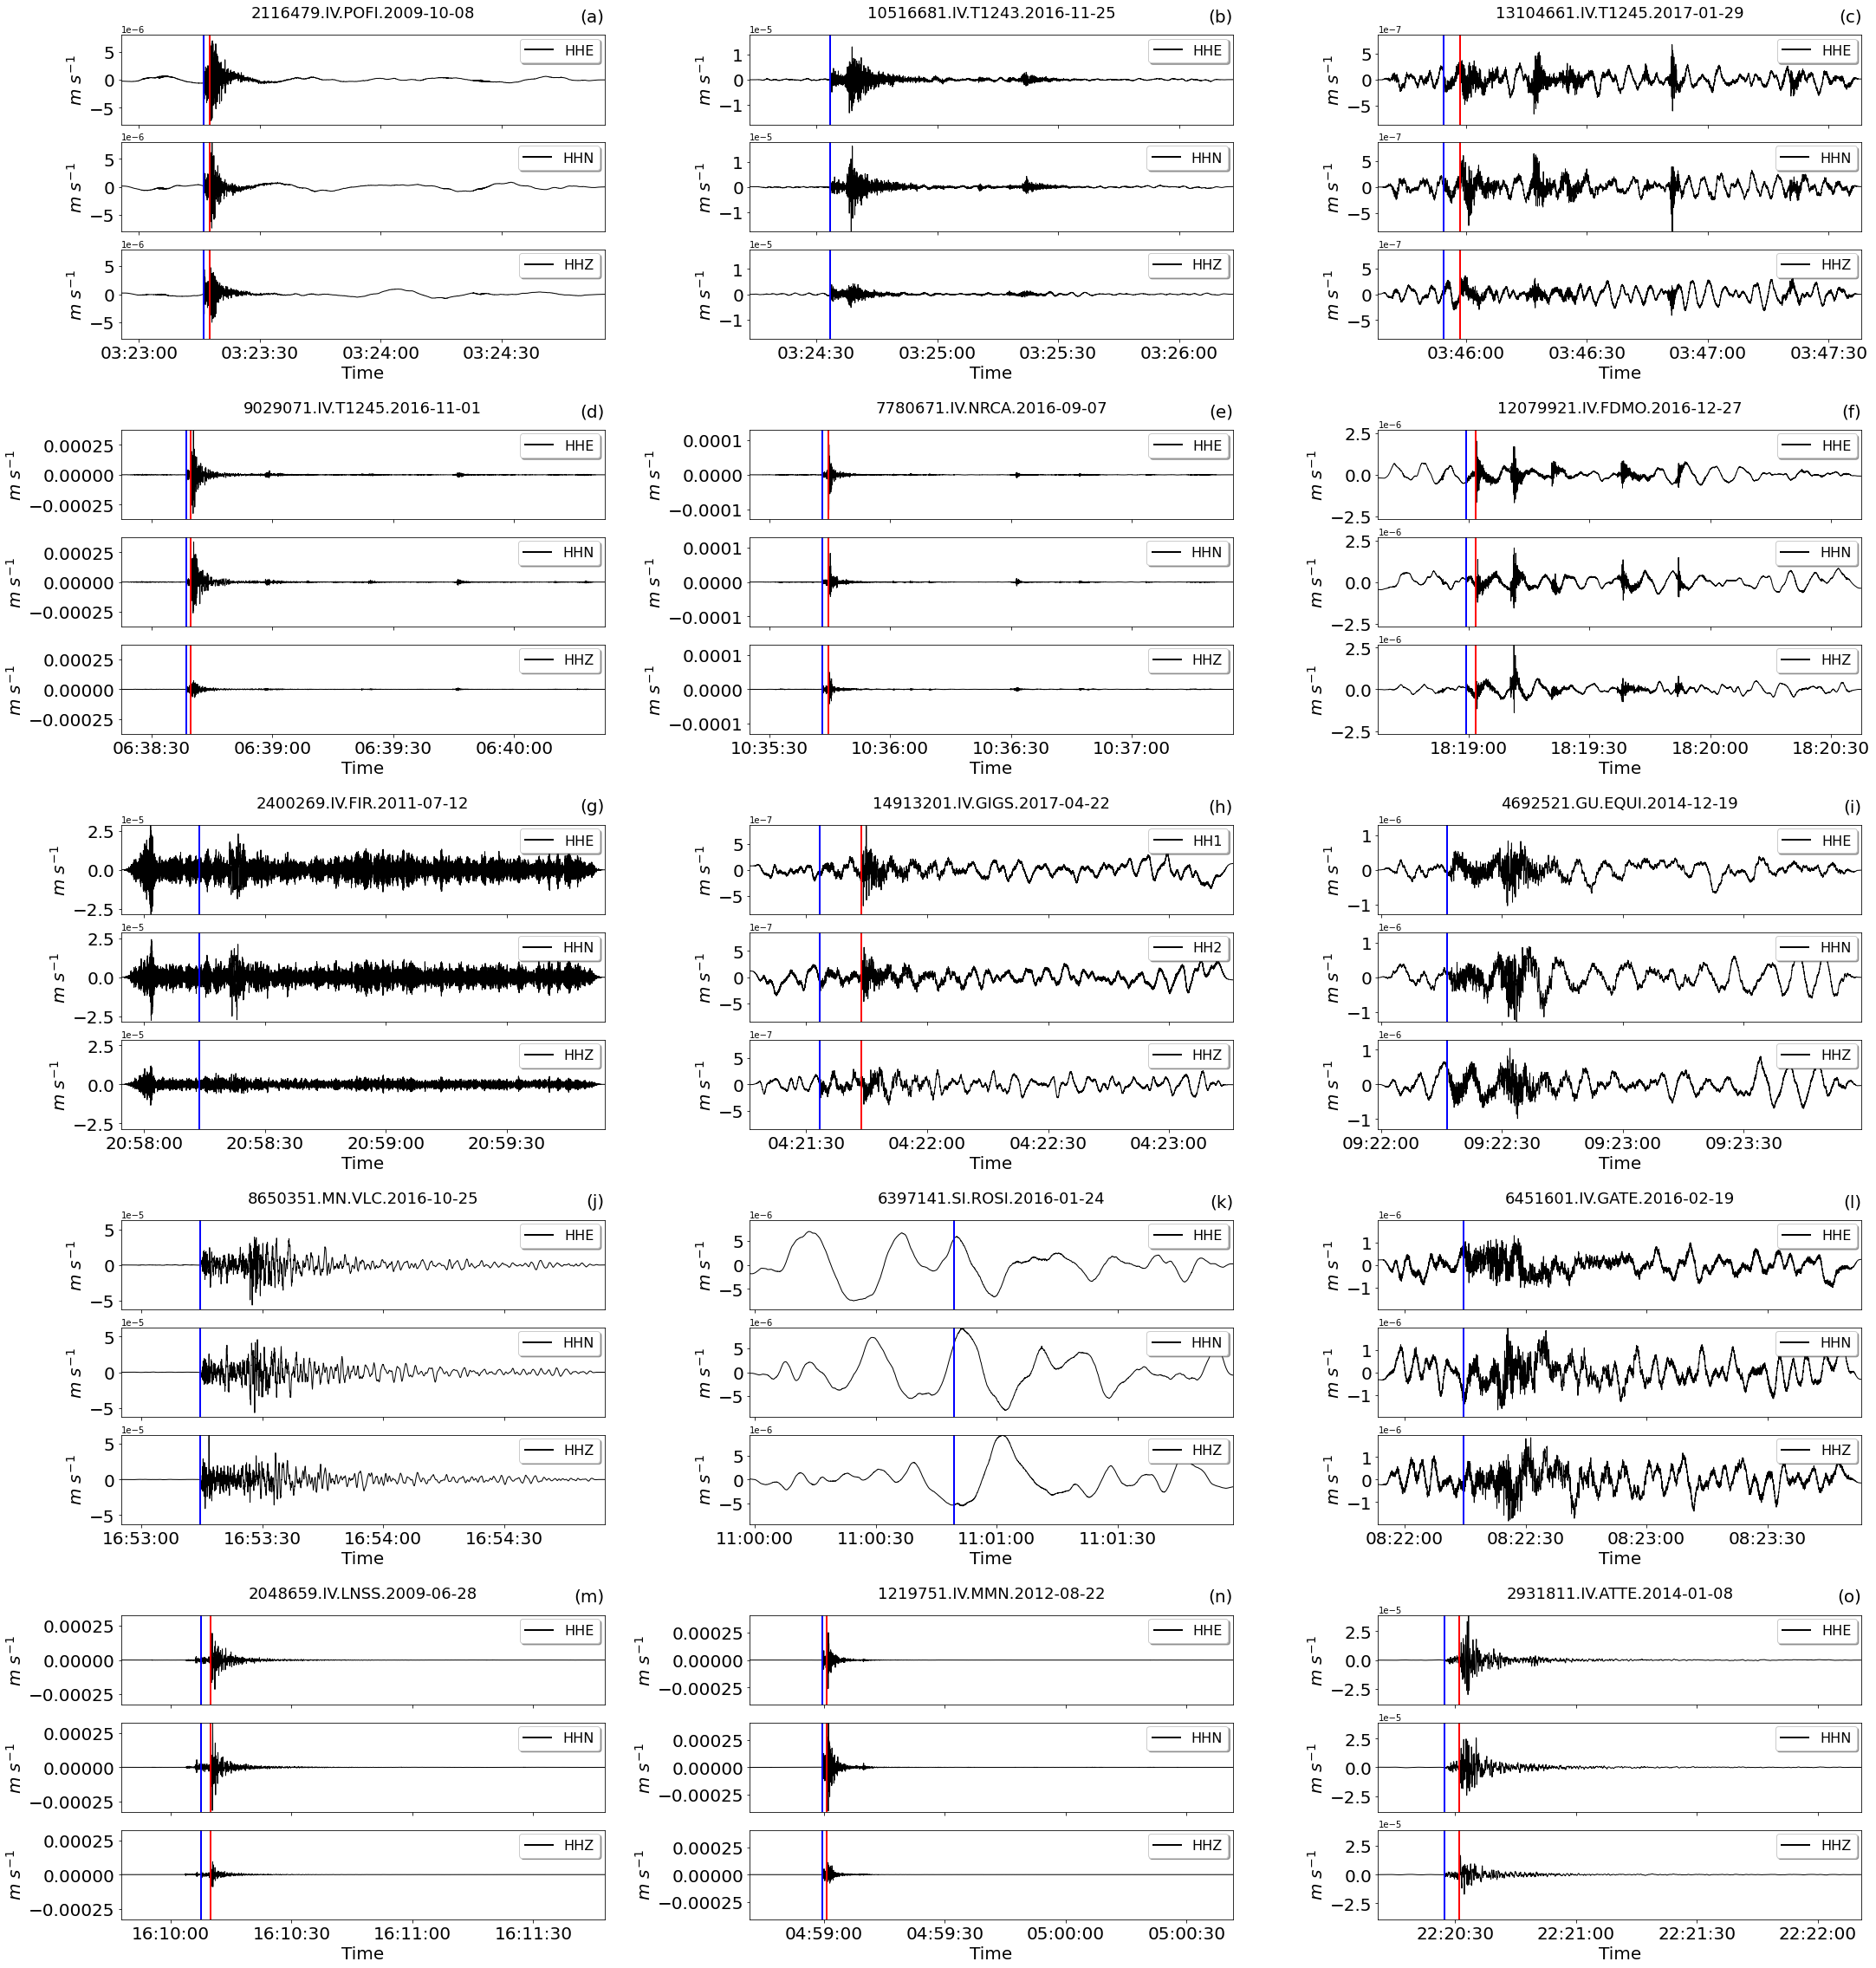

In [43]:
units = ["$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$"]
wftype = 'ev_gm'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

gm_figname=os.path.join(FIGDIR,'wegm_15.png')
plt.savefig(gm_figname,dpi=300)


# Select waveforms for Figure 16
Example of randomly selected event waveforms in ground motion units of the HH, EH and HN channels in INSTANCE. The traces are representative of 75% of the data and belonging to the second, third and fourth quartiles of each channel. Each row contains three randomly selected traces drawn as follows: (a-f) HH traces with `trace_pga_perc`>5.1e-4 % g; (g-l) EH traces with `trace_pga_perc`>9.3e-4 % g; (m-r) HN traces with `trace_pga_perc`>8.7e-4 % g; The arrival times of P- and S-wave onsets are shown by blue andred vertical lines, respectively

## Select based on PGA  in the 75% of data (i.e., from 25% to 100%)

### 1) HH channels

In [42]:
cha = 'HH'
df_tmp = events_metaData[(events_metaData['station_channels'].isin([cha]))]

In [43]:
TOTAL = df_tmp.shape[0]
TOTAL

3893

In [44]:
# 25%
pgav = 5.1e-4

In [45]:
chosen_lines = []
plots_line = 3

In [46]:
neqs = 6
df_tmp = events_metaData.loc[ (events_metaData.trace_pga_perc > pgav) &
                    (events_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=neqs, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  3257 % total:  83.66298484459286


[8854, 3198, 1079, 4965, 5097, 3871]

### 2) EH channels

In [47]:
cha = 'EH'
df_tmp = events_metaData[(events_metaData['station_channels'].isin([cha]))]

In [48]:
TOTAL = df_tmp.shape[0]
TOTAL

2517

In [49]:
# 25%
pgav = 9.3e-4

In [50]:
#
neqs = 6
df_tmp = events_metaData.loc[ (events_metaData.trace_pga_perc > pgav) &
                    (events_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=neqs, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  2132 % total:  84.70401271354787


[8854, 3198, 1079, 4965, 5097, 3871, 4147, 5518, 3413, 4001, 3206, 1397]

### 3) HN channels

In [51]:
cha = 'HN'
df_tmp = events_metaData[(events_metaData['station_channels'].isin([cha]))]


In [52]:
TOTAL = df_tmp.shape[0]
TOTAL

3550

In [53]:
# 25%
pgav = 8.7e-4

In [54]:
#
neqs = 6
df_tmp = events_metaData.loc[(events_metaData.trace_pga_perc > pgav) & 
                            (events_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=neqs, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  3077 % total:  86.67605633802818


[8854,
 3198,
 1079,
 4965,
 5097,
 3871,
 4147,
 5518,
 3413,
 4001,
 3206,
 1397,
 4950,
 5002,
 5699,
 8829,
 5364,
 5250]

# PLOT EVENTS IN GROUND MOTION UNITS

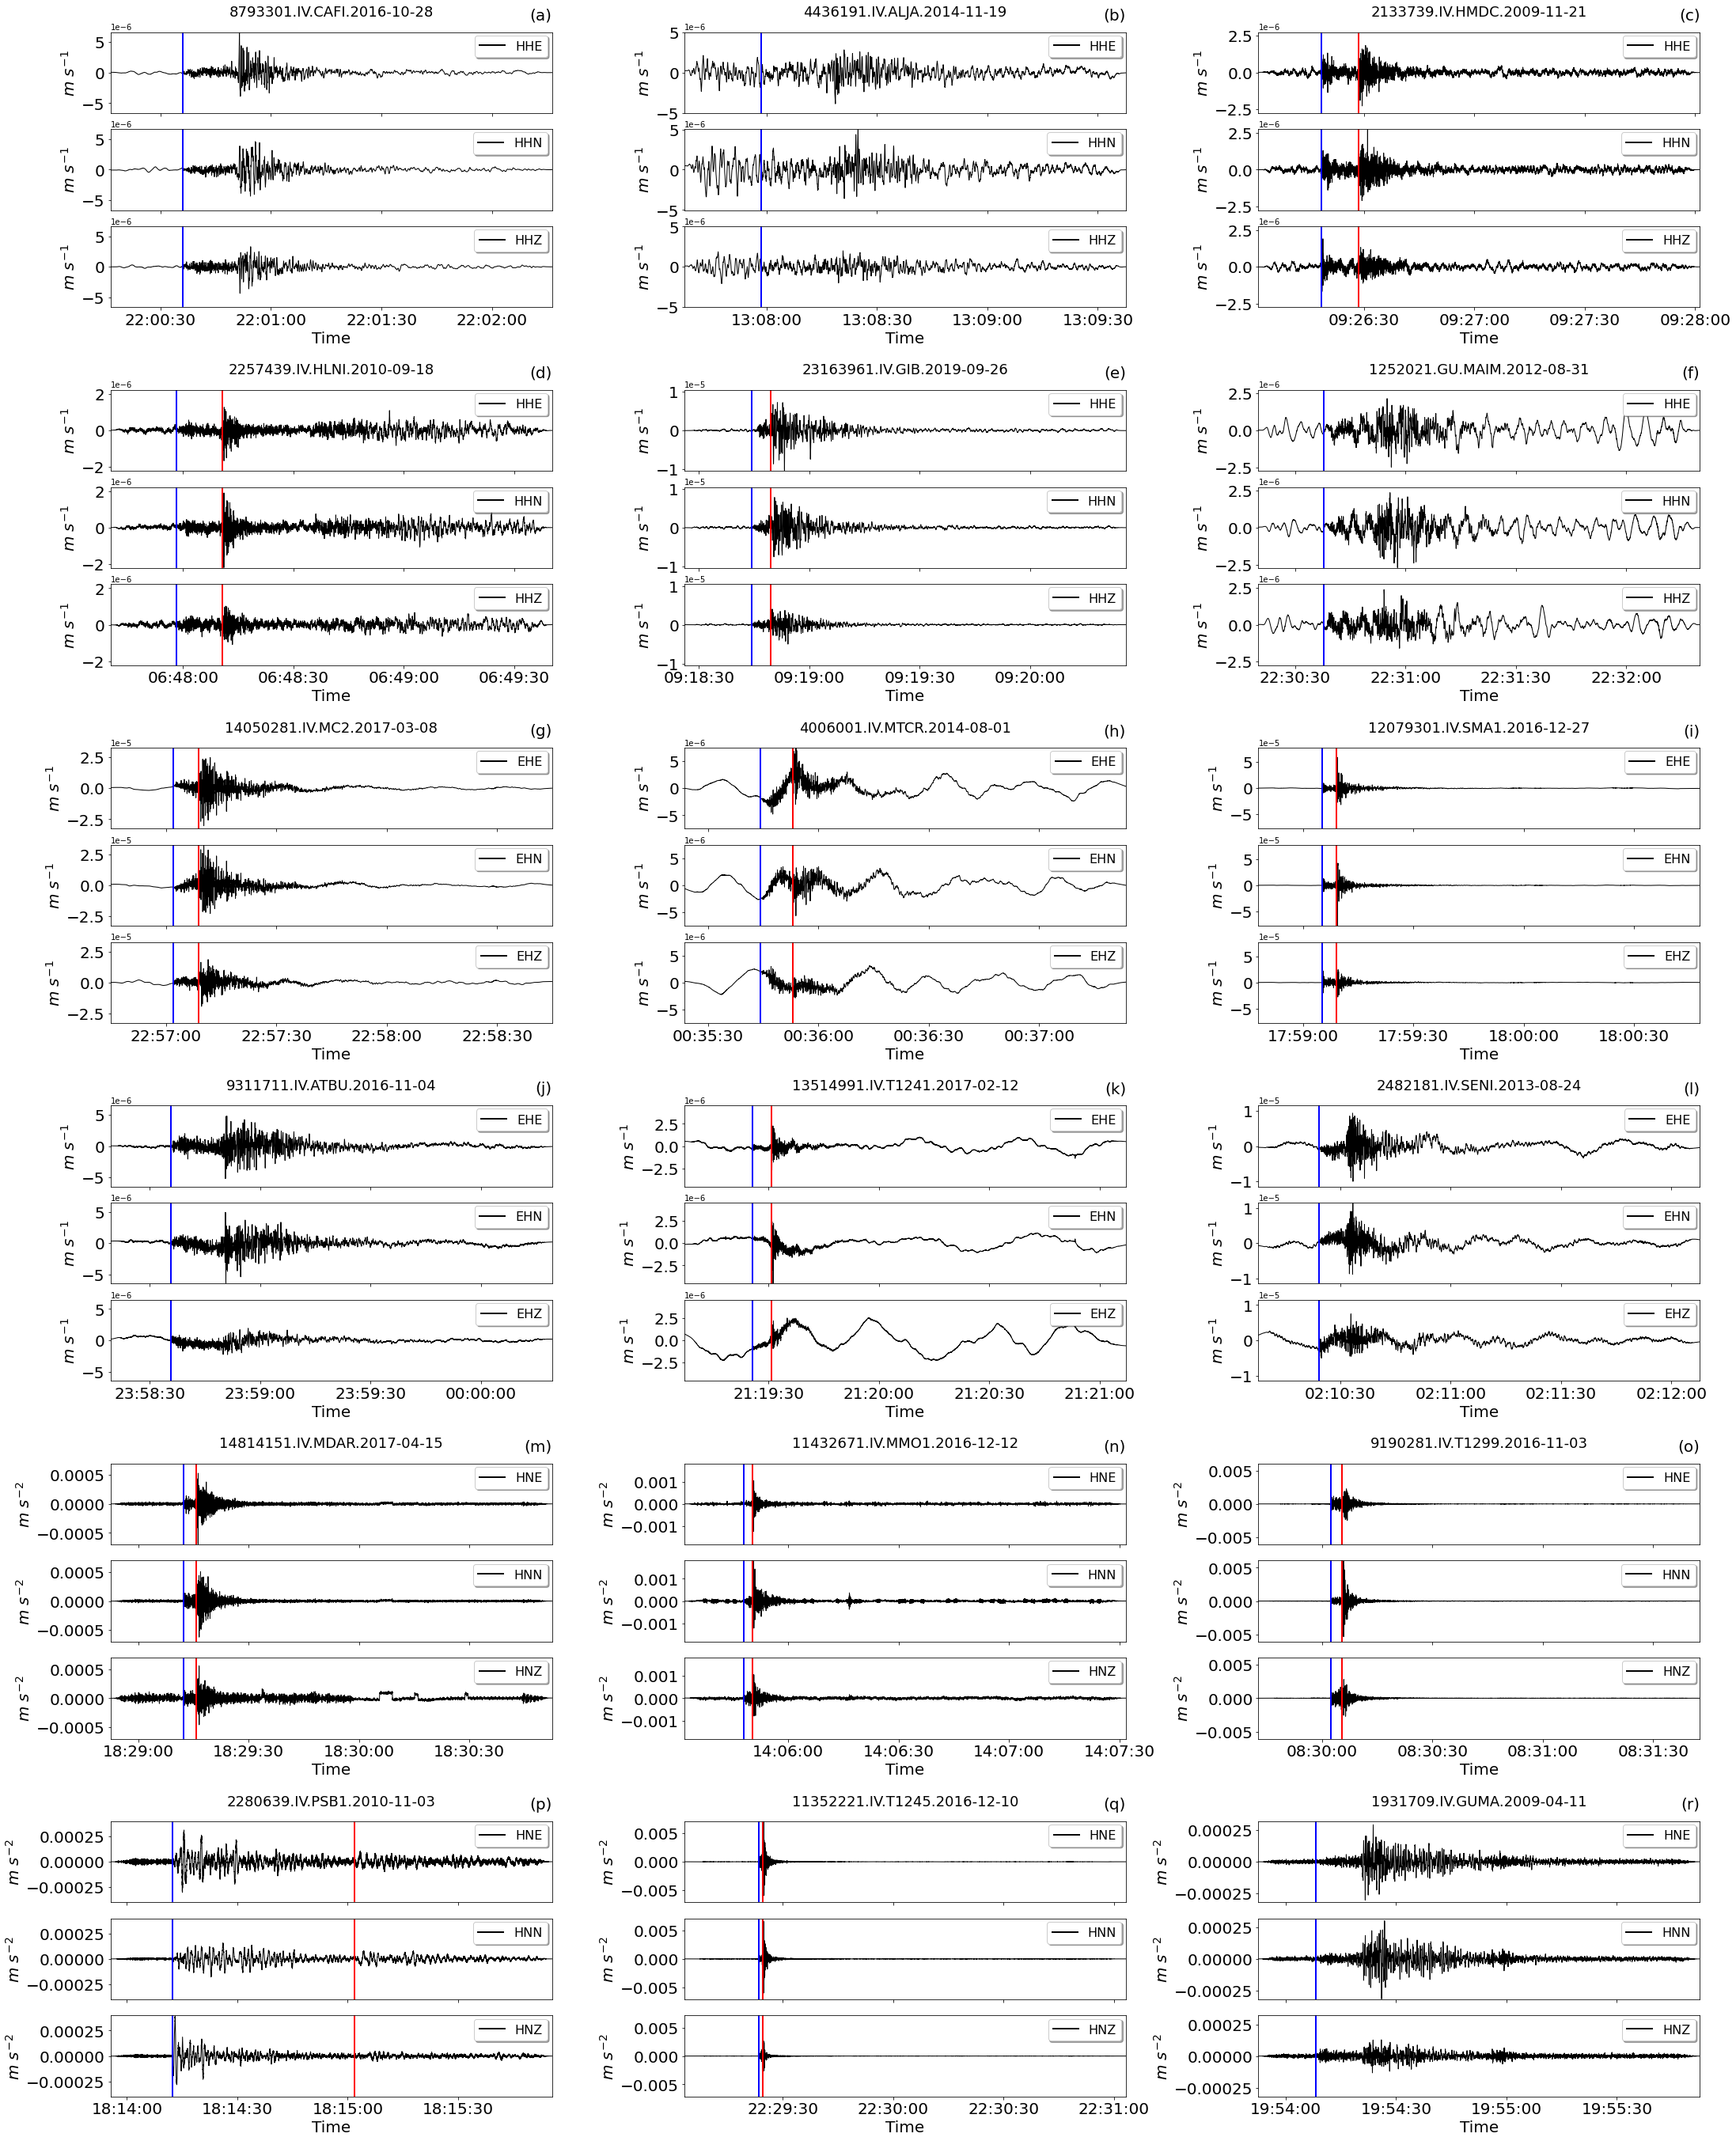

In [57]:
lines = chosen_lines
# Kind of unit
units = ["$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$","$m~s^{-1}$",
         "$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$","$m~s^{-2}$"]

# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=6
ncol=plots_line
labs = alllabs[:(ncol*nrow)]

wftype = 'ev_gm'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)

figname=os.path.join(FIGDIR,'wegm_16.png')
plt.savefig(figname,dpi=300)



# Select noise waveform for Figure 20
Example   of   randomly   selected   noise   waveforms   of   the   HH   and   EH   channels   contained   in   INSTANCE.   Each row   contains   three   randomly   selected   traces   drawn   according   to   the   following   criteria:   (a-c) `trace_GPD_[P,S]_number`>3   (11.6   %   of   the   total   of   the   EH   channels);   (d-f) `trace_EQT_number_detections`>3   (0.13   %   of   the   total   ofthe  EH  channels);  (g-i)  all  the `trace_[E,N,Z]_rms_counts`<[1013,1071,793]  (86.31  %  of  the  total  of  the  HH  chan-nels);  (j-l)  any  of  the `trace_[E,N,Z]_rms_counts`>[1013,1071,793]  (13.69  %  of  the  total  of  the  HH  channels);  (m-o)  all  the `trace_[E,N,Z]_rms_counts`<[327.1,332,307]  (86.36  %  of  the  total  of  the  EH  channels);  (p-r)  any  of  the `trace_[E,N,Z]_rms_counts`>[327.1,332,307] (13.64 % of the total of the EH channels)

In [55]:
cha = "HH"

In [56]:
noise_metaData['trace_E_max'] =  pd.to_numeric(noise_metaData['trace_E_max_counts'], errors='coerce')
noise_metaData['trace_EQT_number_detections'] =  pd.to_numeric(noise_metaData['trace_EQT_number_detections'], errors='coerce')
noise_metaData['trace_GPD_P_number'] =  pd.to_numeric(noise_metaData['trace_GPD_P_number'], errors='coerce')
noise_metaData['trace_GPD_S_number'] =  pd.to_numeric(noise_metaData['trace_GPD_S_number'], errors='coerce')

KeyError: 'trace_E_max_counts'

In [57]:
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

6585

### Define selection criteria based on metadata statistics

In [61]:
df_tmp = noise_metaData.loc[(noise_metaData.station_channels == cha)]
percents = [0.1, 0.25, 0.75, 0.9]
df_tmp[['trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
        'trace_E_rms_counts', 'trace_N_rms_counts','trace_Z_rms_counts']].describe(percentiles=percents)

trace_E_median_counts  trace_N_median_counts  trace_Z_median_counts  \
count           6.338000e+04           6.338000e+04           63380.000000   
mean            8.328014e+01           1.005993e+03              70.885563   
std             1.967029e+04           8.458868e+04            4339.336878   
min            -1.918465e+05          -4.991720e+06         -176787.500000   
10%            -1.555000e+01          -1.600000e+01             -10.000000   
25%            -4.000000e+00          -4.000000e+00              -3.000000   
50%             0.000000e+00           0.000000e+00               0.000000   
75%             4.000000e+00           4.000000e+00               3.000000   
90%             1.600000e+01           1.600000e+01              10.000000   
max             4.927264e+06           6.272884e+06          379181.500000   

       trace_E_rms_counts  trace_N_rms_counts  trace_Z_rms_counts  
count        6.338000e+04        6.338000e+04        63380.000000  
mean         9.630890e+02        2.797376e+03          686.674586  
std          7.667404e+04        1.445380e+05        14699.447835  
min          0.000000e+00        0.000000e+00            0.000000  
10%          5.279480e+01        5.346980e+01           44.679000  
25%          1.015880e+02        1.019990e+02           85.419750  
50%          2.050305e+02        2.072820e+02          166.302500  
75%          4.478507e+02        4.657660e+02          363.953250  
90%          1.013397e+03        1.071159e+03          793.117200  
max          1.919350e+07        1.901990e+07       998641.711000

In [62]:
cha='EH'

In [63]:
df_tmp = noise_metaData.loc[(noise_metaData.station_channels == cha)]
percents = [0.1, 0.25, 0.75, 0.9]
df_tmp[['trace_E_median_counts','trace_N_median_counts','trace_Z_median_counts',
        'trace_E_rms_counts', 'trace_N_rms_counts','trace_Z_rms_counts']].describe(percentiles=percents)

trace_E_median_counts  trace_N_median_counts  trace_Z_median_counts  \
count           27161.000000           27161.000000           27161.000000   
mean               -1.866260              -0.263374              -1.040021   
std               214.554792             110.131792             167.869497   
min            -32567.500000           -6946.000000          -19200.000000   
10%                -2.000000              -2.000000              -2.000000   
25%                 0.000000               0.000000               0.000000   
50%                 0.000000               0.000000               0.000000   
75%                 0.000000               0.000000               0.000000   
90%                 2.000000               2.000000               2.000000   
max              9940.000000            9380.500000           12403.000000   

       trace_E_rms_counts  trace_N_rms_counts  trace_Z_rms_counts  
count        27161.000000        27161.000000        27161.000000  
mean           215.470152          194.910146          191.208346  
std           4956.197475         2371.708881         4291.147616  
min              0.000000            0.000000            0.457000  
10%              7.530000            7.864000            5.639000  
25%             22.923000           22.878000           18.438000  
50%             58.288000           57.647000           50.091000  
75%            141.798000          140.947000          119.818000  
90%            327.145000          332.634000          307.069000  
max         754046.925000       291265.690000       623629.186000

In [64]:
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

27161

In [65]:
chosen_lines = []
plots_line = 3

#### 1) `trace_GPD_[PS]_number` > 3 & `station_channels` = 'EH'

In [66]:
df_tmp = noise_metaData.loc[((noise_metaData.trace_GPD_P_number > 3) | (noise_metaData.trace_GPD_S_number > 3)) &
                   (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  3163 % total:  11.645373881668569


[108273, 58434, 114192]

#### 2) `trace_EQT_number_detection` > 3 & `station_channels` = 'EH'

In [67]:
df_tmp = noise_metaData.loc[(noise_metaData.trace_EQT_number_detections > 3) & 
                   (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  36 % total:  0.13254298442619933


[108273, 58434, 114192, 119078, 119791, 118546]

#### 3) `trace_[E,N,Z]_rms_counts`<[1013,1071,793] & `station_channels` = 'HH'

In [68]:
cha = 'HH'
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

63380

In [69]:
min_E_rms = 1013
min_N_rms = 1071
min_Z_rms = 793

df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts <  min_E_rms) & 
                             (noise_metaData.trace_N_rms_counts <  min_N_rms) &
                             (noise_metaData.trace_Z_rms_counts <  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  54723 % total:  86.34111707163143


[108273, 58434, 114192, 119078, 119791, 118546, 102455, 45665, 95219]

#### 4) at least one of `trace_[E,N,Z]_rms_counts`>[1013,1071,793] & `station_channels` = 'HH'

In [70]:
df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts >  min_E_rms) | 
                             (noise_metaData.trace_N_rms_counts >  min_N_rms) |
                             (noise_metaData.trace_Z_rms_counts >  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  8657 % total:  13.658882928368572


[108273,
 58434,
 114192,
 119078,
 119791,
 118546,
 102455,
 45665,
 95219,
 124466,
 104149,
 99845]

Selectes # 25221

#### 5) all `trace_[E,N,Z]_rms_counts`<[327.1,332,307] & `station_channels` = 'EH'

In [71]:
cha = 'EH'
TOTAL = noise_metaData.loc[noise_metaData.station_channels == cha].shape[0]
TOTAL

27161

In [72]:
min_E_rms = 327.1
min_N_rms = 332
min_Z_rms = 307
df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts <  min_E_rms) & 
                             (noise_metaData.trace_N_rms_counts <  min_N_rms) &
                             (noise_metaData.trace_Z_rms_counts <  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  23439 % total:  86.29652811015795


[108273,
 58434,
 114192,
 119078,
 119791,
 118546,
 102455,
 45665,
 95219,
 124466,
 104149,
 99845,
 58613,
 98390,
 127293]

#### 6) at least one og the `trace_[E,N,Z]_rms_counts`<[327.1,332,307] & `station_channels` = 'EH'

In [73]:
df_tmp = noise_metaData.loc[((noise_metaData.trace_E_rms_counts >  min_E_rms) | 
                             (noise_metaData.trace_N_rms_counts >  min_N_rms) |
                             (noise_metaData.trace_Z_rms_counts >  min_Z_rms)) &
                             (noise_metaData.station_channels == cha)]

ntot = df_tmp.shape[0]
print ("N records: ", ntot, "% total: ", float(ntot/TOTAL * 100.))
#
lista = list(df_tmp.sample(n=plots_line, random_state=1).index)
chosen_lines = chosen_lines + lista
chosen_lines

N records:  3722 % total:  13.703471889842053


[108273,
 58434,
 114192,
 119078,
 119791,
 118546,
 102455,
 45665,
 95219,
 124466,
 104149,
 99845,
 58613,
 98390,
 127293,
 9012,
 58360,
 124973]

# PLOT NOISE

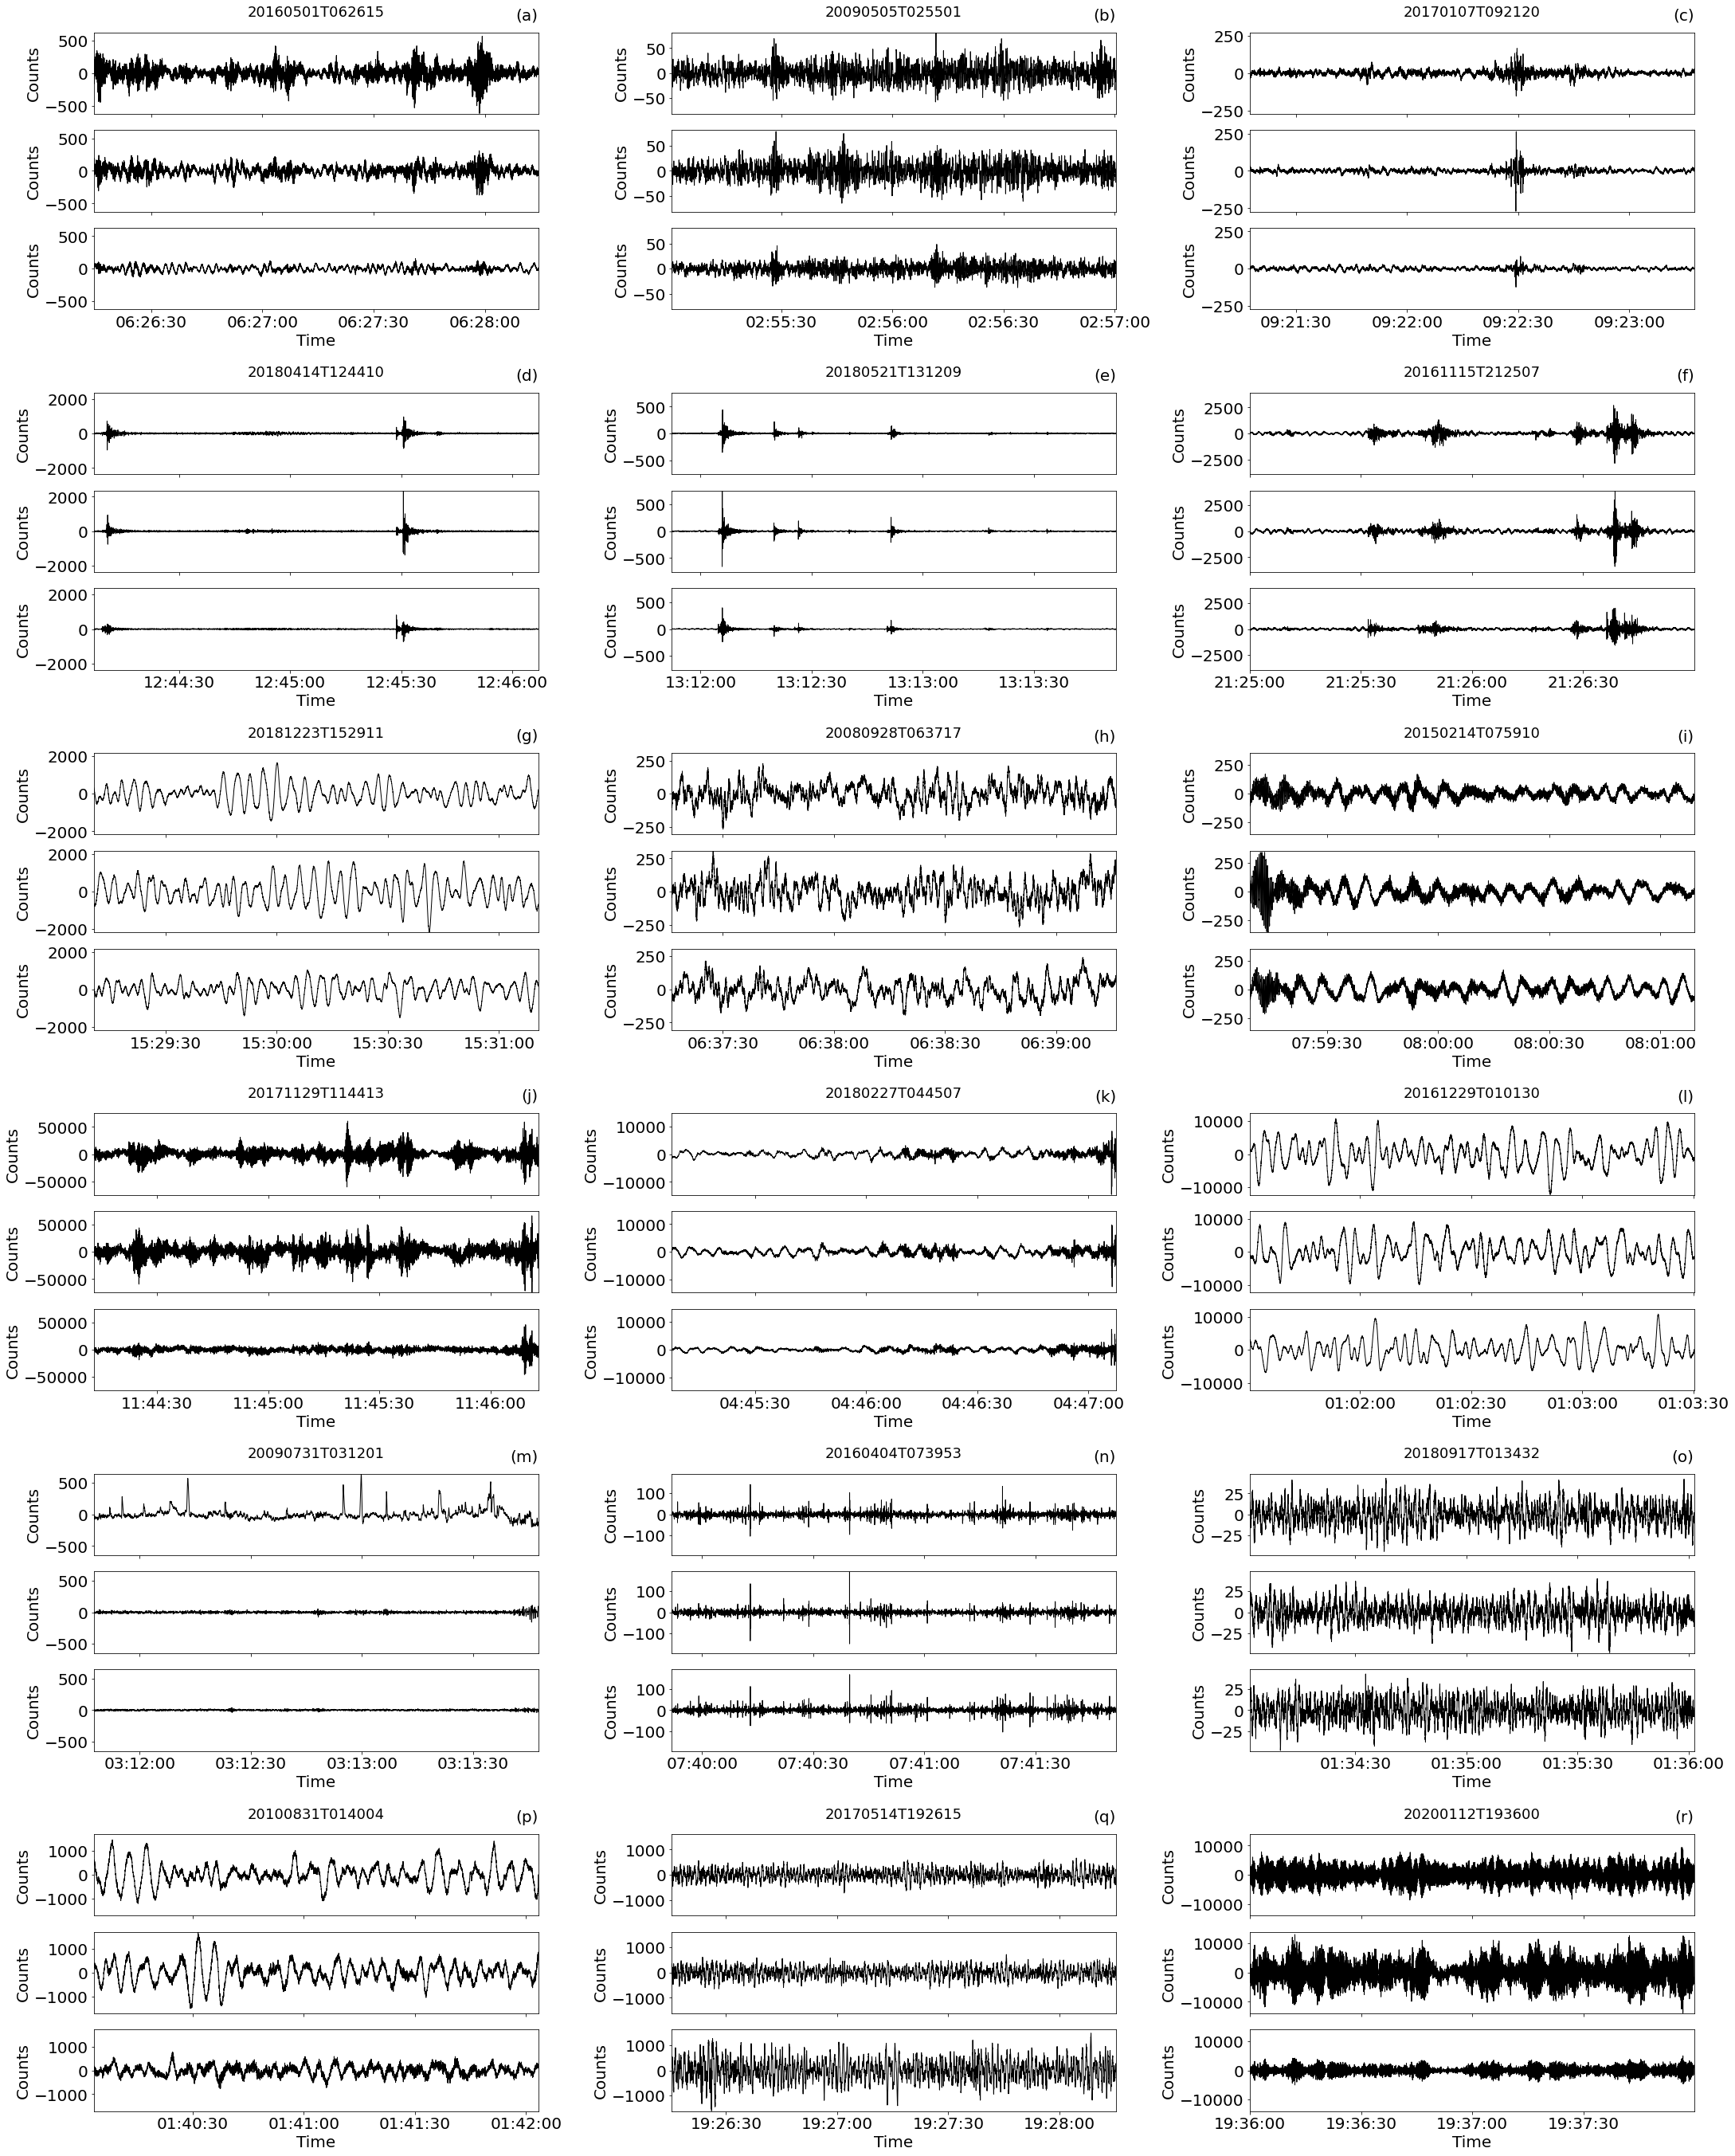

In [74]:
lines = chosen_lines
# Kind of unit
units = ["Counts","Counts","Counts","Counts","Counts","Counts",
         "Counts","Counts","Counts","Counts","Counts","Counts",
         "Counts","Counts","Counts","Counts","Counts","Counts"]


# Do you want the traces filtered?
filt = False
freq_min=3.0
freq_max=20.0

nrow=6
ncol=plots_line
labs = alllabs[:(ncol*nrow)]


wftype = 'noise'
if wftype == 'ev_c':
    df = events_metaData
    h5 = events_h5File
elif wftype == 'ev_gm':
    df = events_metaData
    h5 = gm_h5File
elif wftype == 'noise':
    df = noise_metaData
    h5 = noise_h5File


multiple_streams(df,h5,lines,wftype,nrow,ncol,units,labs,filt,freq_min,freq_max)


noise_figname=os.path.join(FIGDIR,'wn_20.png')
plt.savefig(noise_figname,dpi=300)

